In [5]:
def normalise(tempcol, set_t):
    return (max(tempcol) - np.array(tempcol)) / (max(tempcol) - set_t)

In [6]:
def unnormalise(tempcol_normalized, set_t):
    return max(tempcol) - (tempcol_normalized * (max(tempcol) - set_t))

### READING THE LOG FILE AND PLOTTING THE TIME RESPONSE

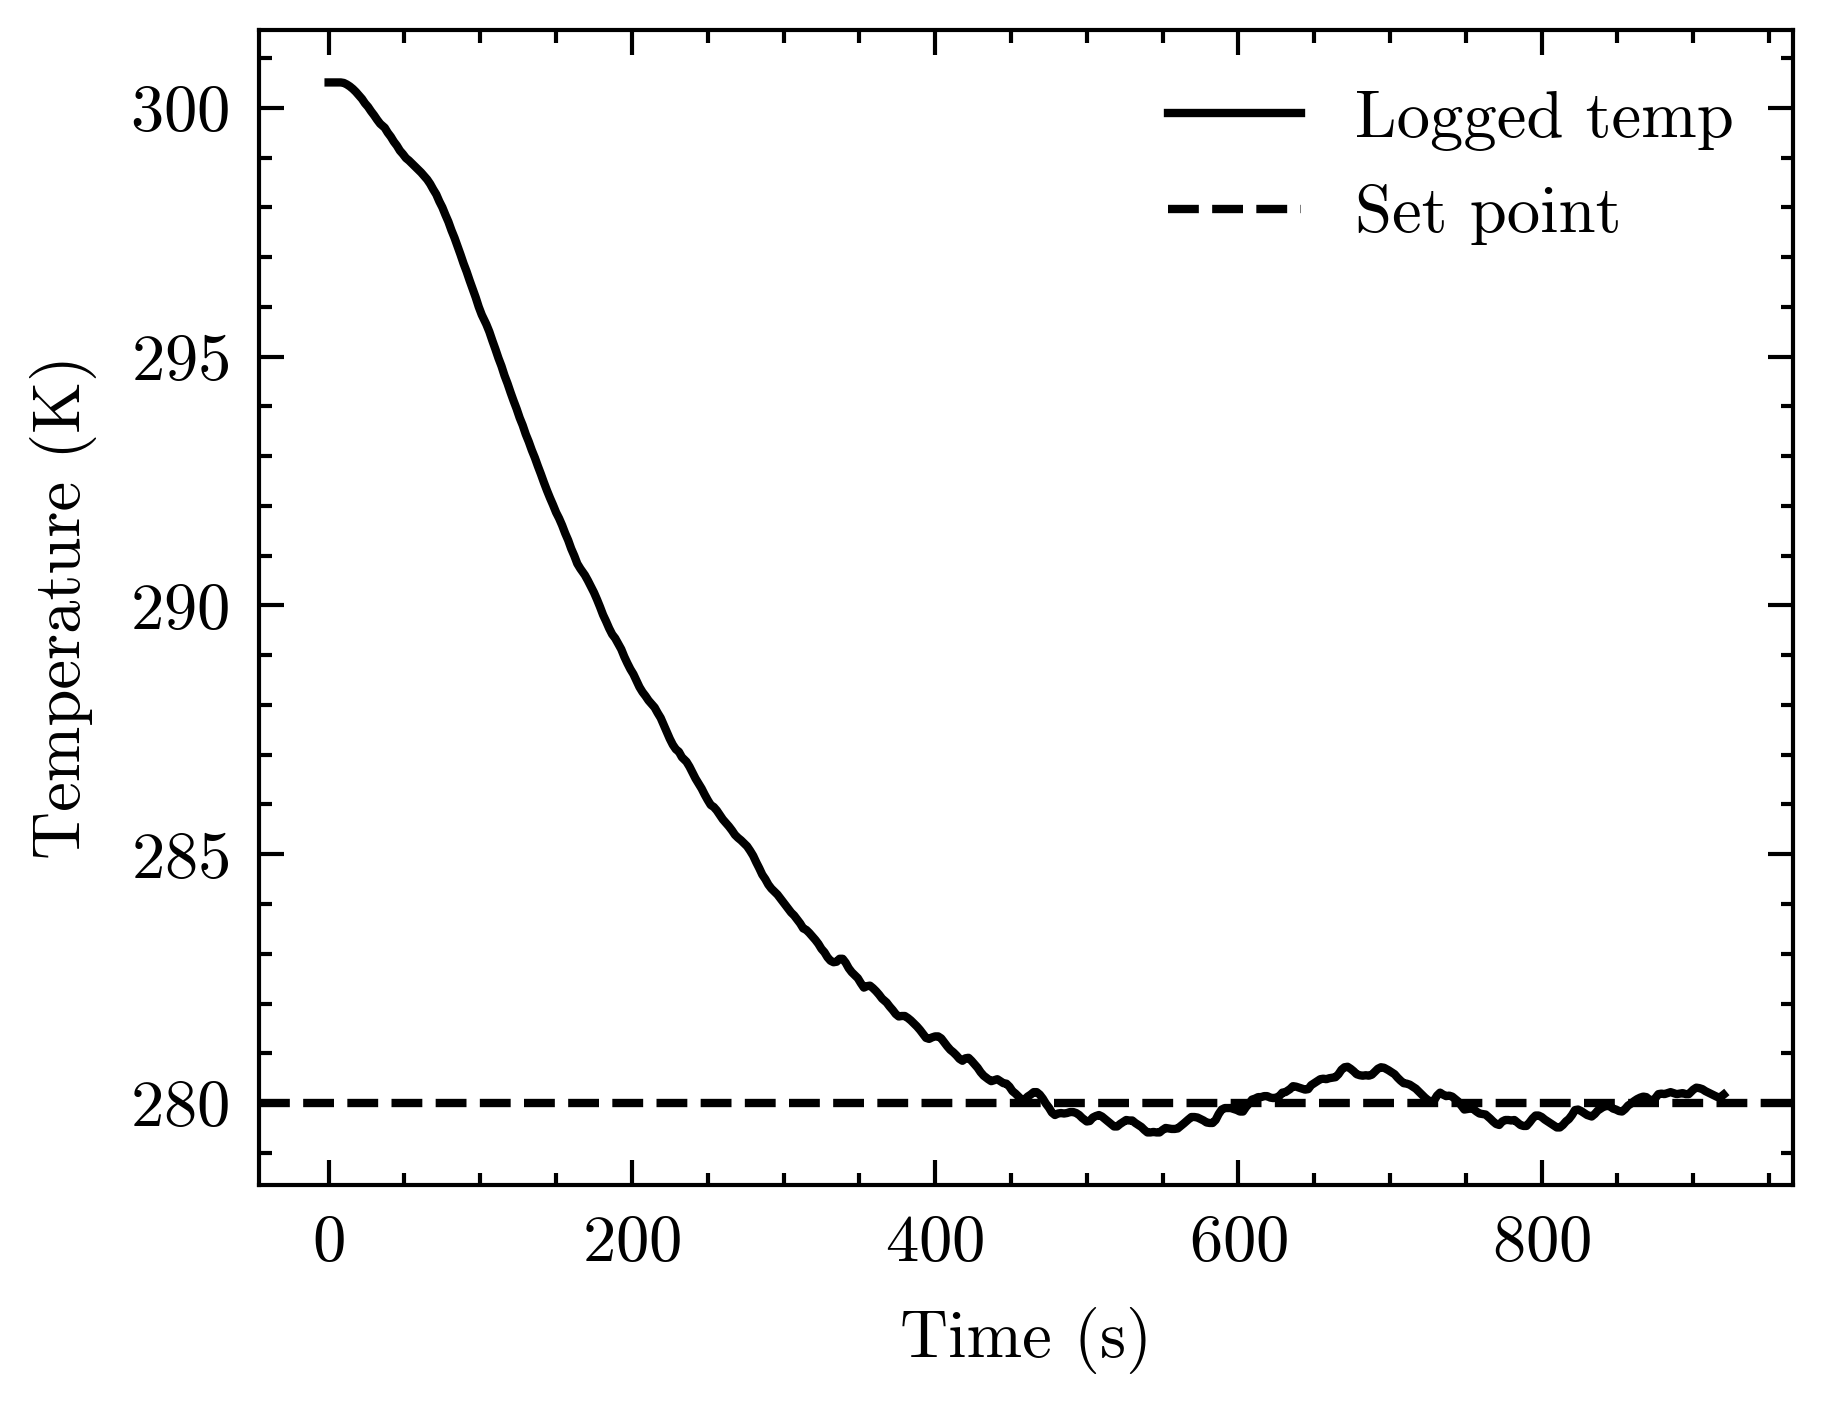

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
import control as ct
import scienceplots
plt.style.use(['science','ieee','no-latex'])
s = ct.TransferFunction.s

# Load data from file
datetimecol = []
tempcol = []

set_t = 280

with open("templog_2024-05-31_10-16-34_to_2024-05-31_10-31-54.txt") as f:
    for line in f:
        temp = line.strip().split()
        datetimecol.append(temp[0] + ' ' + temp[1])
        tempcol.append(float(temp[2]))

# Convert datetime strings to datetime objects
time_series = pd.to_datetime(datetimecol)

# Calculate elapsed time in seconds since the start
elapsed_time_seconds = (time_series - time_series[0]).total_seconds()

# Plot
plt.figure()
plt.plot(elapsed_time_seconds, tempcol, label = 'Logged temp')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.axhline(set_t, linestyle='dashed', label = 'Set point')

plt.legend(loc="best")
plt.savefig('log_3105.pdf', dpi=300)
plt.show()

In [3]:
max(tempcol)

300.51

### NORMALIZING AND PLOTTING THE LOG DATA

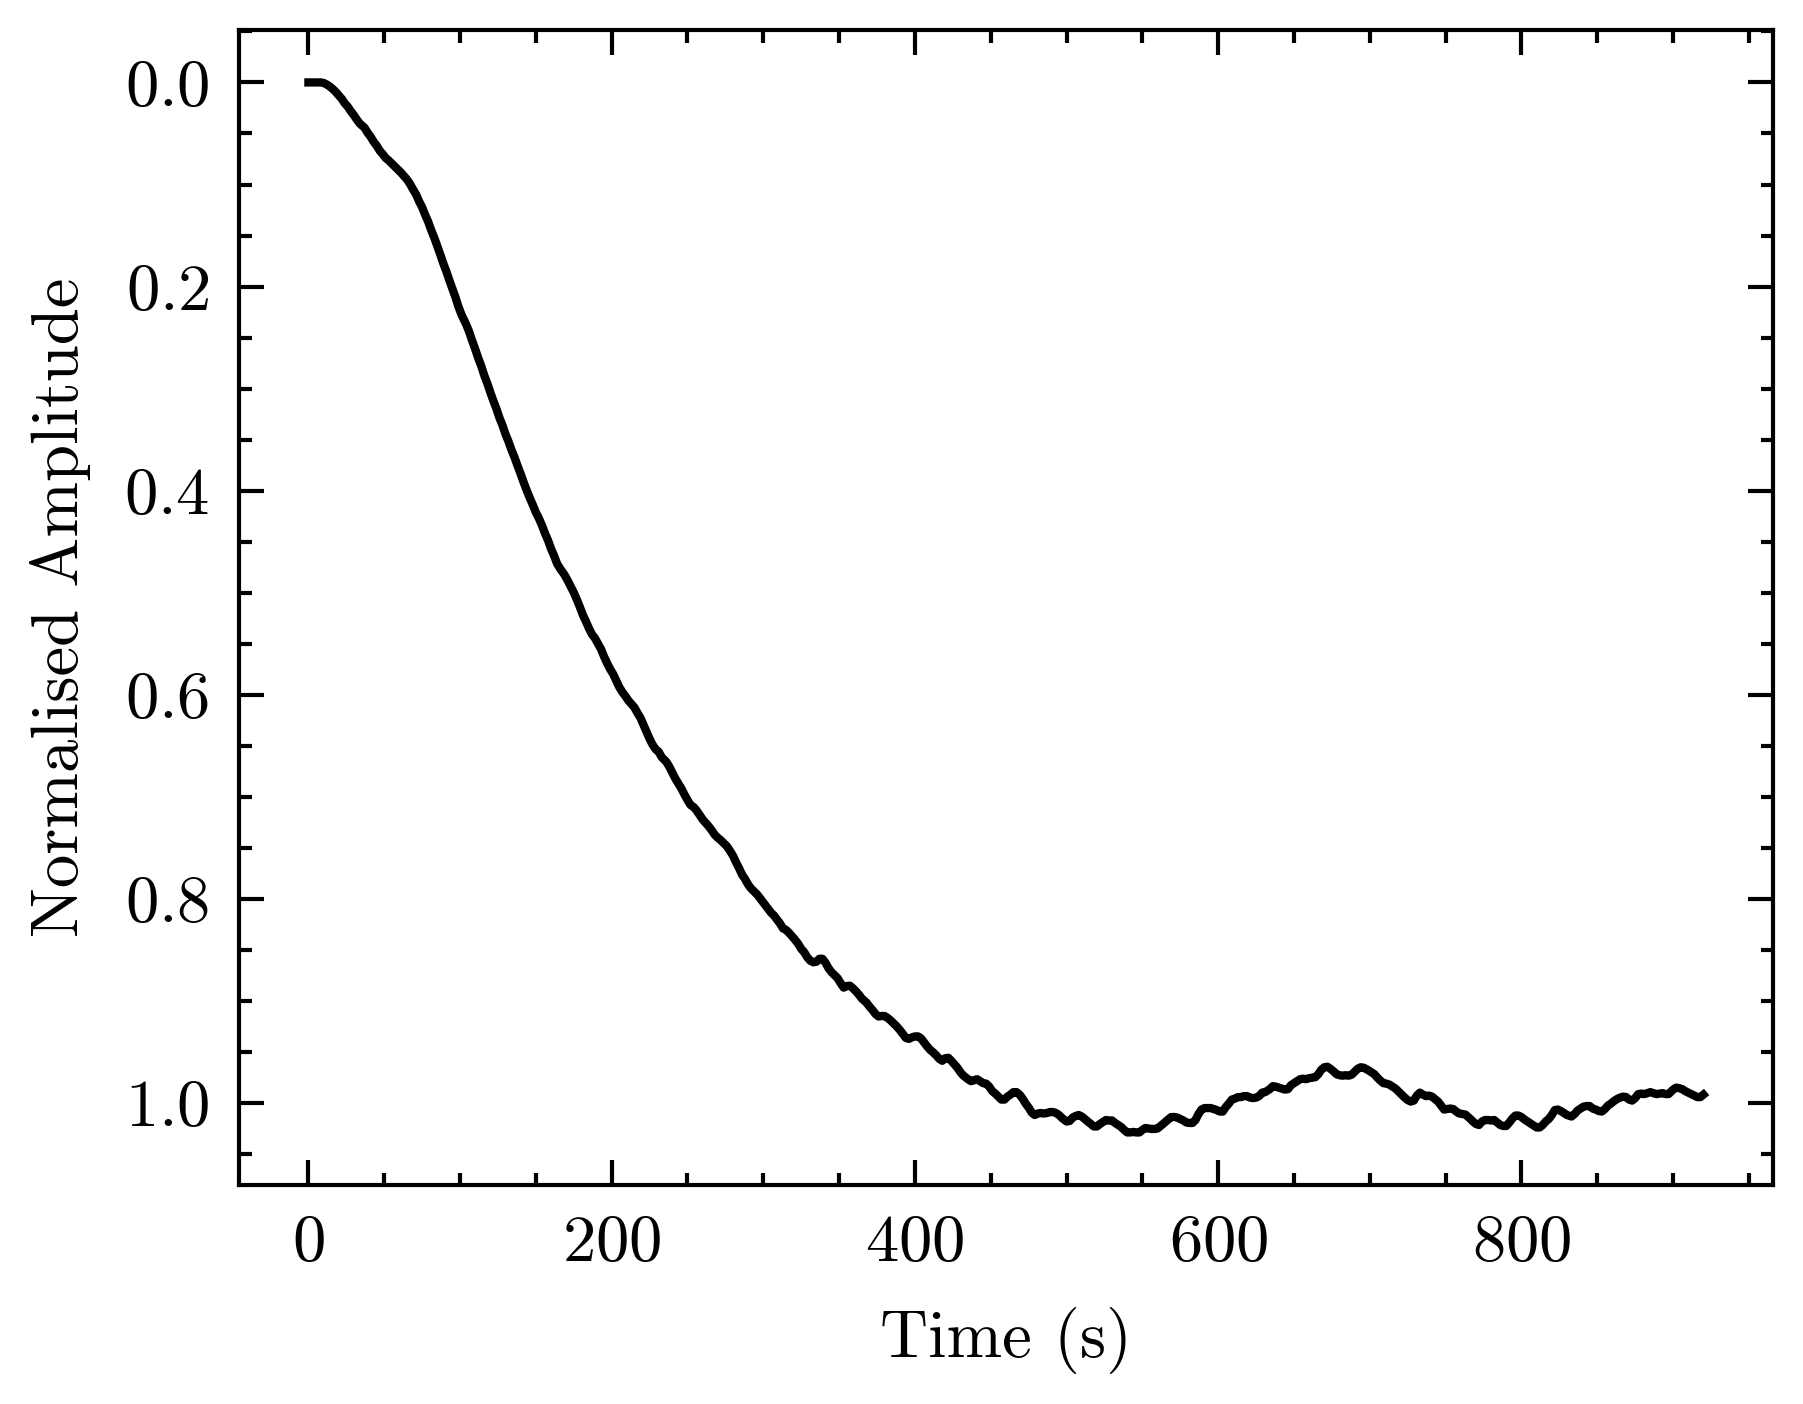

In [7]:
# Calculate elapsed time in seconds since the start
elapsed_time_seconds = (time_series - time_series[0]).total_seconds()

# Normalize temperature values
tempcol_normalized = normalise(tempcol, set_t)

# Plot
plt.figure()
plt.plot(elapsed_time_seconds, tempcol_normalized)
plt.xlabel('Time (s)')
plt.ylabel('Normalised Amplitude')
plt.gca().invert_yaxis()


plt.show()

In [17]:
max(testcol), min(testcol)

(300.51, 279.41)

### unNORMALIZING AND PLOTTING THE LOG DATA TO CHECK

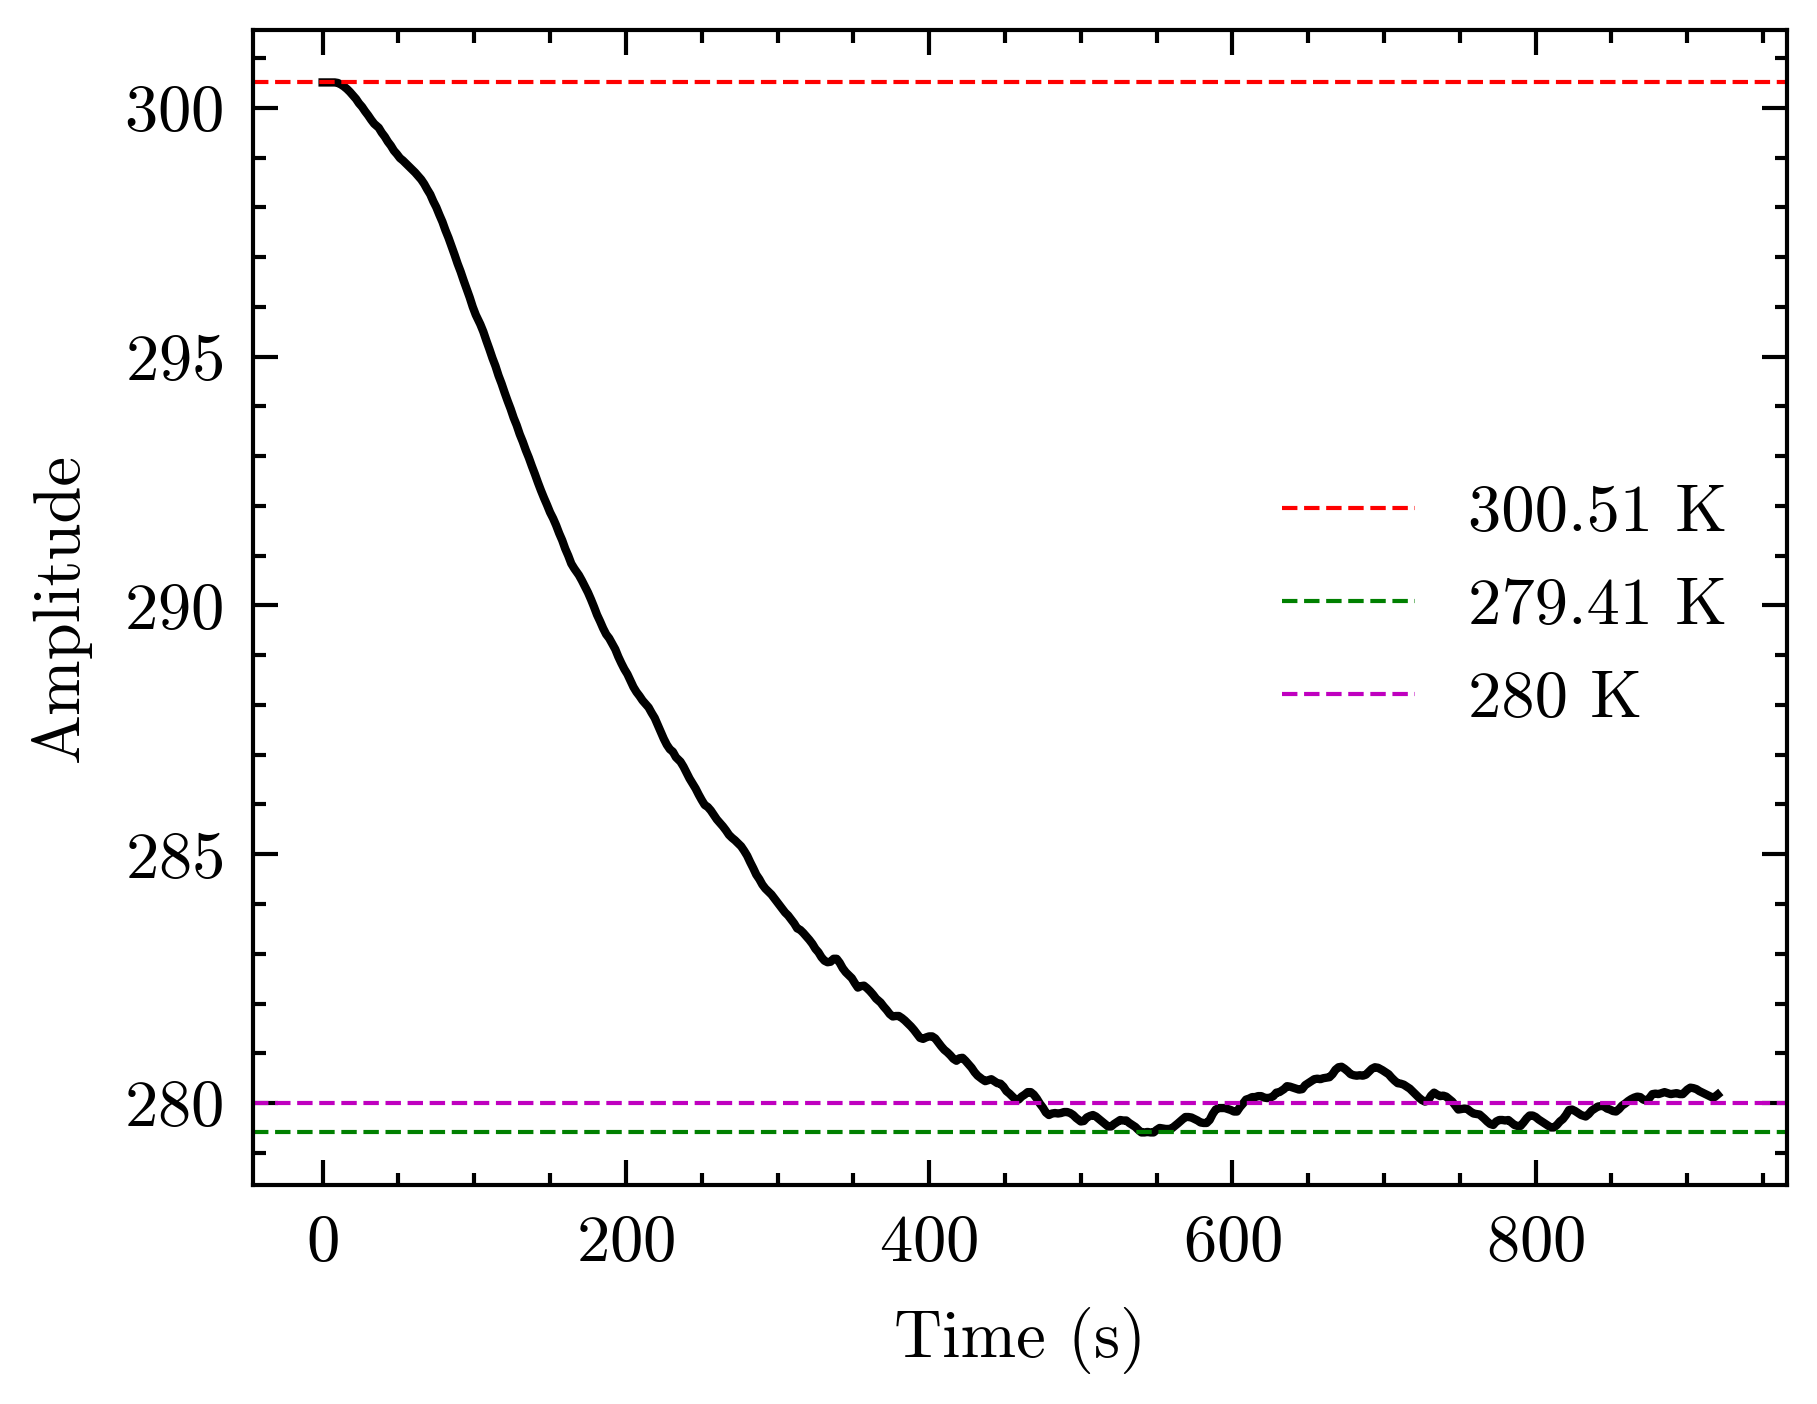

In [9]:
# Calculate elapsed time in seconds since the start
elapsed_time_seconds = (time_series - time_series[0]).total_seconds()

# Normalize temperature values
testcol = unnormalise(tempcol_normalized, set_t)

# Plot
plt.figure()
plt.plot(elapsed_time_seconds, testcol)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.gca().invert_yaxis()
#plt.axhline(1, linestyle='dashed')  # Adjusted dashed line
plt.axhline(max(testcol), linestyle='dashed', color='r', linewidth = 0.5, label = f'{max(testcol)} K')  # Adjusted dashed line
plt.axhline(min(testcol), linestyle='dashed', color='g', linewidth = 0.5, label = f'{min(testcol)} K')  # Adjusted dashed line
plt.axhline(280, linestyle='dashed', color='m', linewidth = 0.5, label = f'280 K')  # Adjusted dashed line
plt.legend(loc="best")

plt.show()

### MIMICKING THE NORMALIZED LOG DATA TO MATCH THE CONTROL OUT CURVE

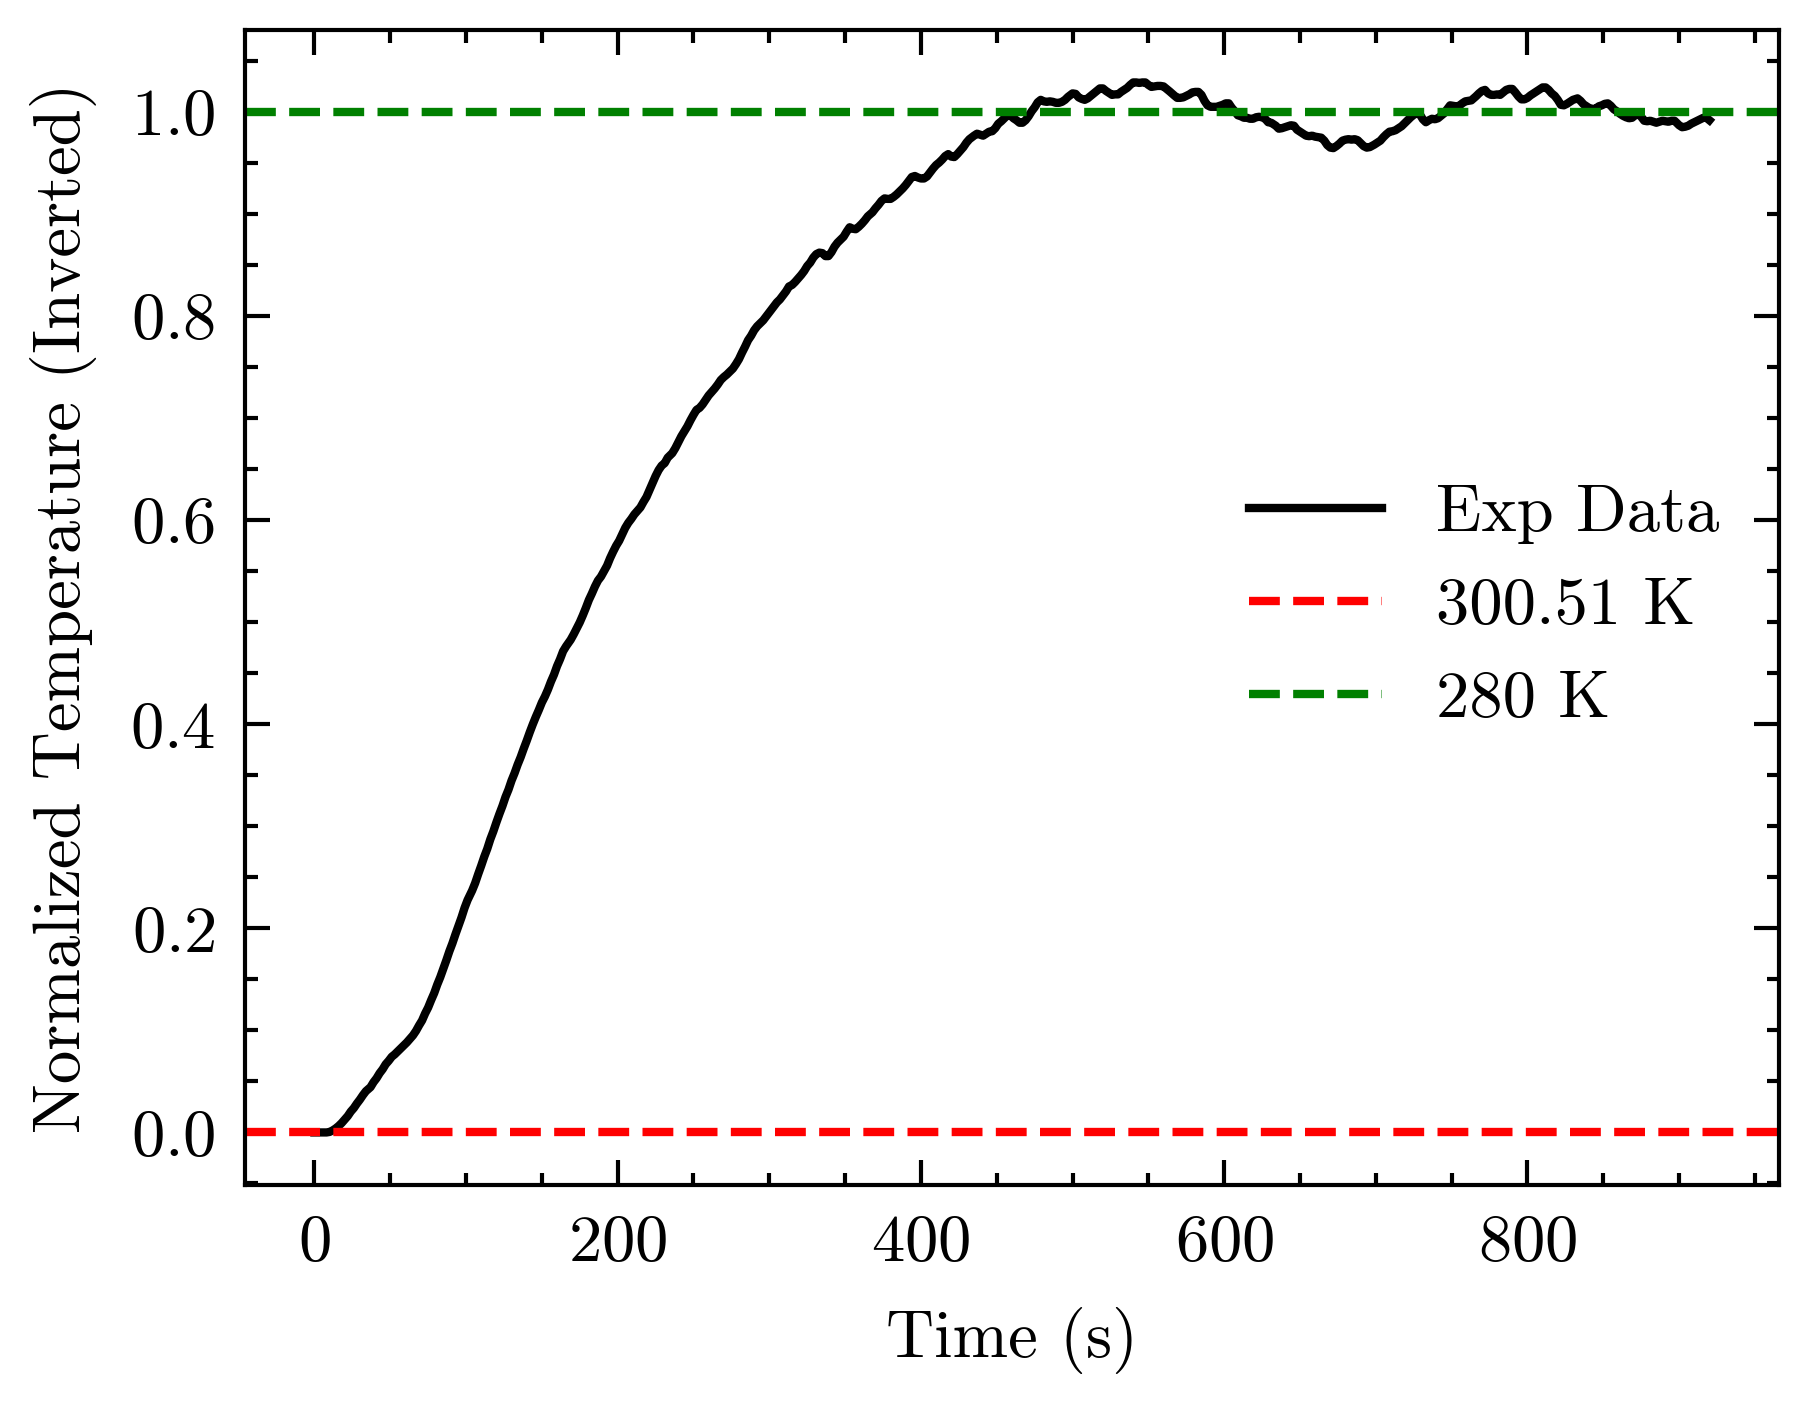

In [10]:
# Calculate elapsed time in seconds since the start
elapsed_time_seconds = (time_series - time_series[0]).total_seconds()

# Normalize temperature values and invert the y-axis
tempcol_normalized = (max(tempcol) - np.array(tempcol)) / (max(tempcol) - set_t)

# Plot
plt.figure()
plt.plot(elapsed_time_seconds, tempcol_normalized, label = 'Exp Data')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Temperature (Inverted)')
plt.axhline(0, linestyle='dashed', color='r', label = '300.51 K')  # Line at 0 (corresponding to 280 K)
plt.axhline(1, linestyle='dashed', color='g', label = '280 K')  # Line at 1 (corresponding to 298.02 K)

plt.legend(loc="best")
plt.savefig('log_3105_norm_inv.pdf', dpi=300)
plt.show()

### PLOTTING THE CLOSED LOOP TF OF EXPERIMENT, MODEL, AFTER TUNING

<TransferFunction>: sys[68]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


               0.0001641
----------------------------------------
0.2 s^3 + 5.005 s^2 + 0.6141 s + 0.01141

<TransferFunction>: sys[71]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.2 s^2 + 5 s + 0.5
-------------------
         s

<TransferFunction>: sys[74]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        3.282e-05 s^2 + 0.0008204 s + 8.204e-05
--------------------------------------------------------
0.2 s^4 + 5.005 s^3 + 0.6142 s^2 + 0.01223 s + 8.204e-05



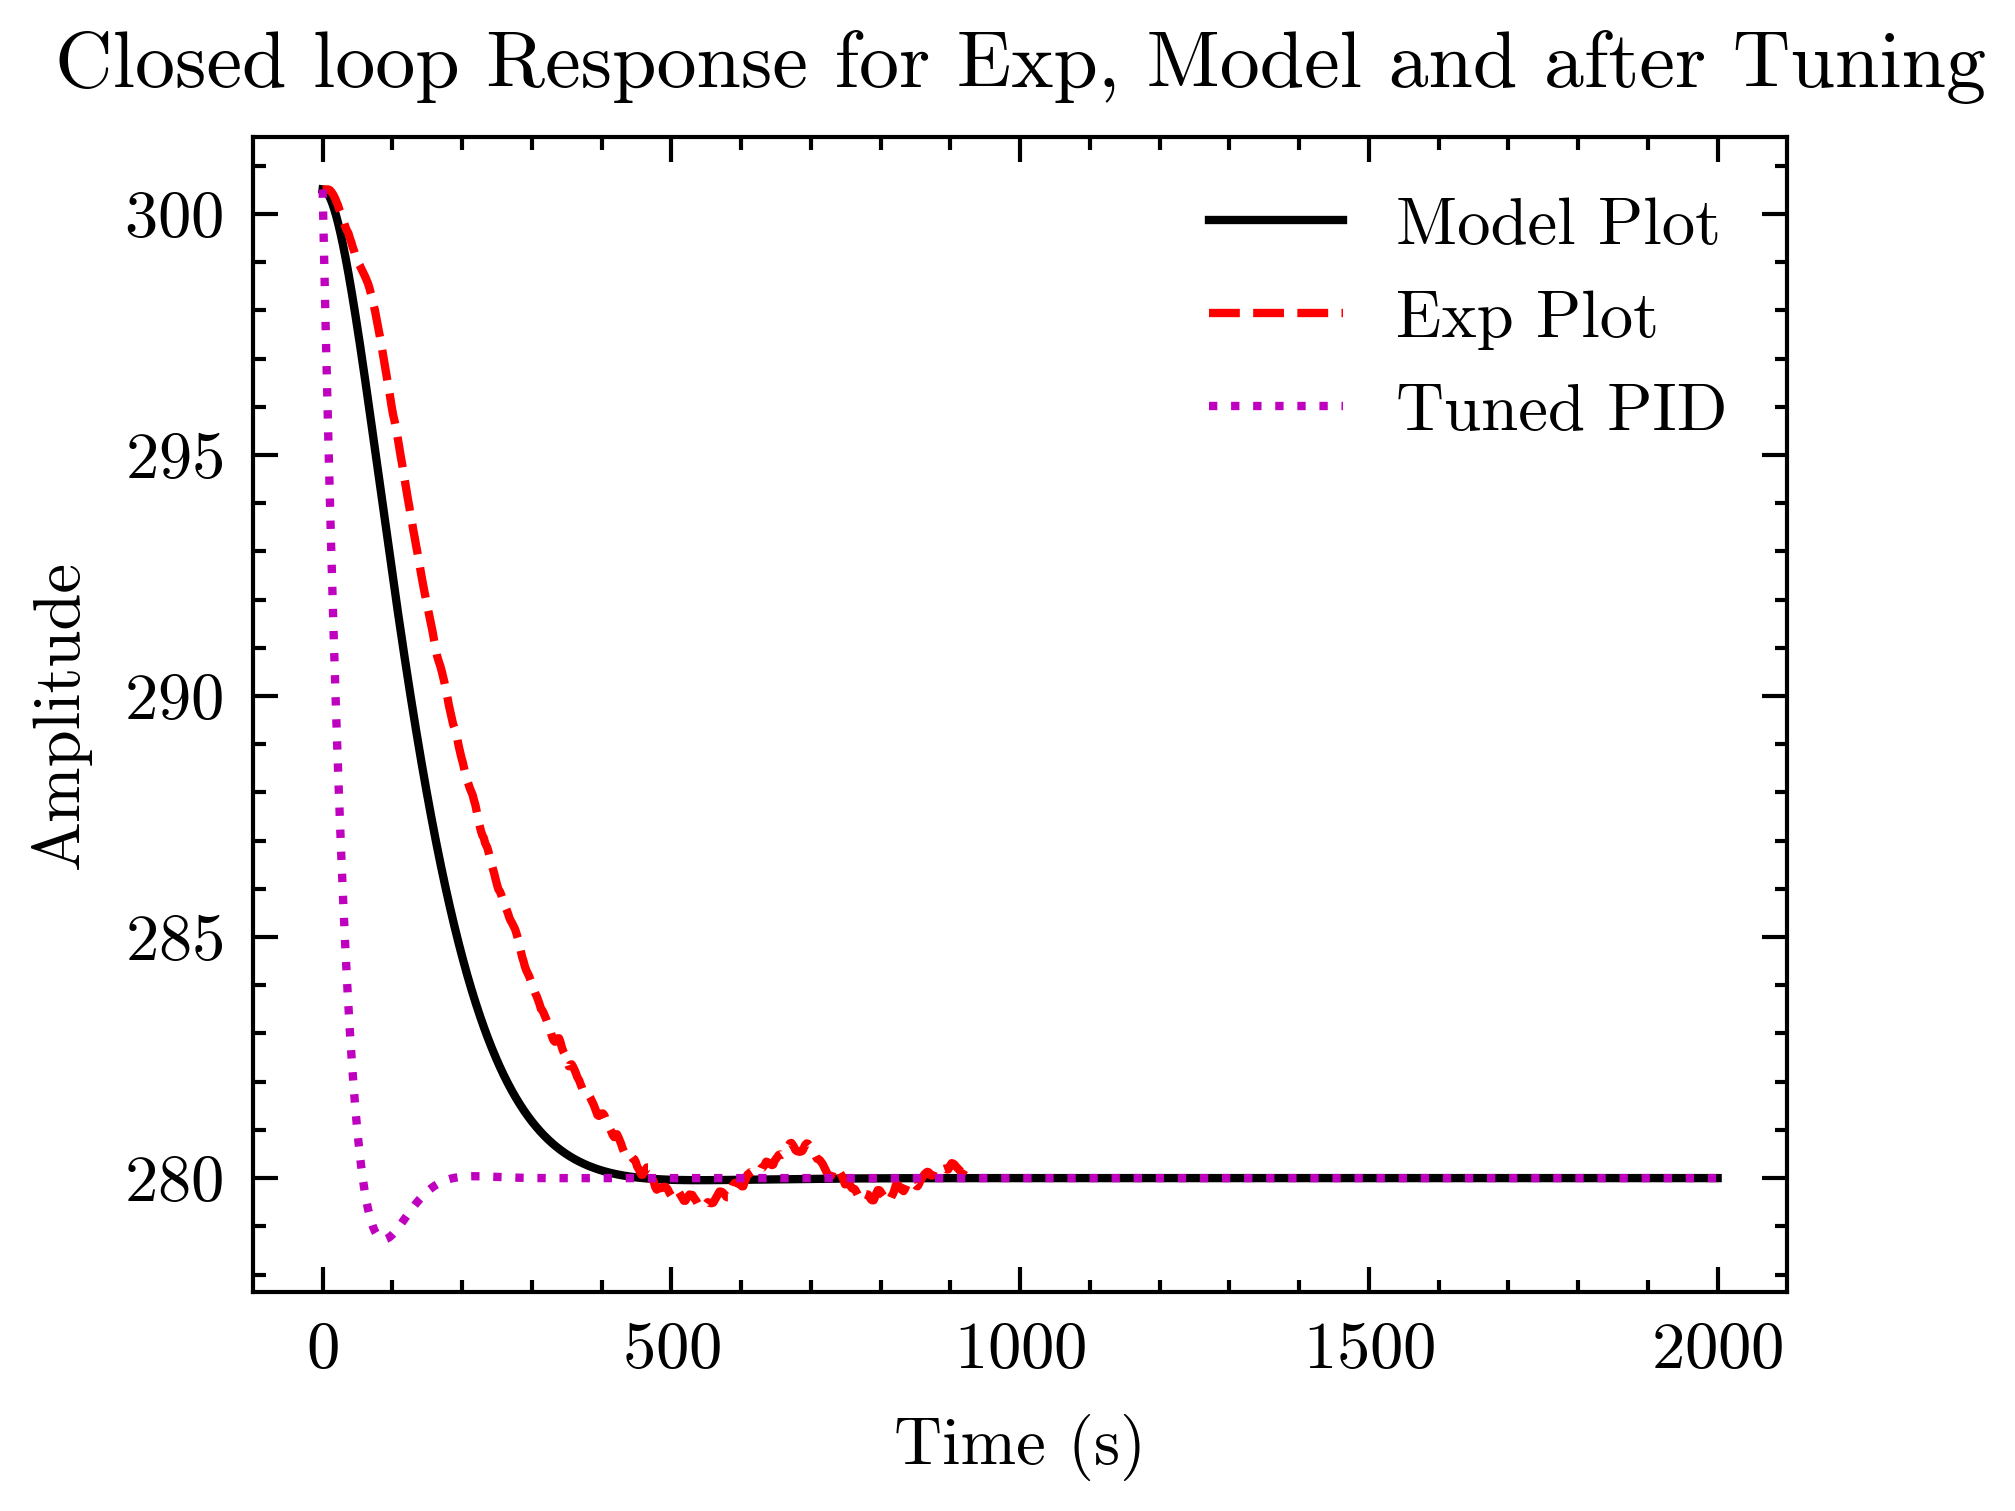

In [44]:
# Extracting the plant TF
kp = 5
ki = 0.5
kd = 0.2

P = (w_n ** 2) / (((s ** 2) * kd + s * kp + ki) * (s + 2 * w_n * damp_f))
print(P)
plt.figure()
t, y = ct.step_response(P)
# plt.plot(t, y)  #check open loop response


#add new pid (model the present system by supplying same PID values)
kp = 5
ki = 0.5
kd = 0.2
C = ct.TransferFunction([kd, kp, ki], [1, 0])
print(C)
T = ct.feedback(C * P, 1)
print(T)
t_model = np.arange(0, 2000, 0.01)
t_model, y_model = ct.step_response(T, t_model)

y_model_unnorm = unnormalise(y_model, set_t)

plt.plot(t_model, y_model_unnorm, color='k', label = 'Model Plot')
plt.plot(elapsed_time_seconds, tempcol, color='r', label = 'Exp Plot')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")


# after tuning
kp = 138.675
ki = 4.1025
kd = 1024.7449
C = ct.TransferFunction([kd, kp, ki], [1, 0])
T = ct.feedback(C * P, 1)

t_tuned = np.arange(0, 2000, 0.01)
t_tuned, y_tuned = ct.step_response(T, t_tuned)
y_tuned_unnorm = unnormalise(y_tuned, set_t)

plt.plot(t_tuned, y_tuned_unnorm, color='m',label = 'Tuned PID')


# plt.axvline(x = rise_time, color='y', linestyle='--', linewidth = 0.5, label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 1)} s')
# plt.axvline(x = peak_timeseries_model, color='b', linestyle='--', linewidth = 0.5, label = '$\mathregular{t_p}$: ' + f'{round(peak_timeseries_model, 1)} s')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")
plt.title('Closed loop Response for Exp, Model and after Tuning')

#plt.savefig('log_3105_model_tuned_exp.pdf', dpi=300)
plt.show()

### CHARACTERIZING THE LOG DATA

In [23]:
# Find peak temperature and peak time
T_peak = min(tempcol)
index_peak = tempcol.index(T_peak)
peaktime = (elapsed_time_seconds[index_peak])

#peaktime = datetime.strptime(str(peak_timeseries), '%Y-%m-%d %H:%M:%S')

peak_time = (peaktime - 0)

# Print peak temperature and peak time
print("Peak temperature:", T_peak, "K")

# Find overshoot
overshoot = ((T_peak - set_t)/set_t) 

# Print percentage overshoot
print("Percentage overshoot:", round((overshoot*100),3), "%")
damp_f = math.sqrt( 1 / ( 1 + ( (math.pi**2) / ((math.log(np.abs(overshoot)))**2) )))
w_n = math.pi / (peak_time * math.sqrt(1 - (damp_f ** 2)))

theta = (math.atan(math.sqrt((1-(damp_f**2))/damp_f)))
rise_time = (math.pi - theta)/(w_n * math.sqrt(1-(damp_f**2)))
print("Peak time:", peak_time, "s")
print("Rise time:", round(rise_time, 1), "s")

print("Damping Factor:", round(damp_f,3))
print("Natural Frequency:", round(w_n,3), "rad/s")

Peak temperature: 279.41 K
Percentage overshoot: -0.211 %
Peak time: 540.0 s
Rise time: 462.9 s
Damping Factor: 0.891
Natural Frequency: 0.013 rad/s


In [12]:
damp_f, w_n

(0.8909081606856718, 0.01280928128794394)

C:\Users\gharj\AppData\Local\Temp\ipykernel_4992\1936691009.py:4: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  index_peak_model = np.where(tempcol == T_peak)


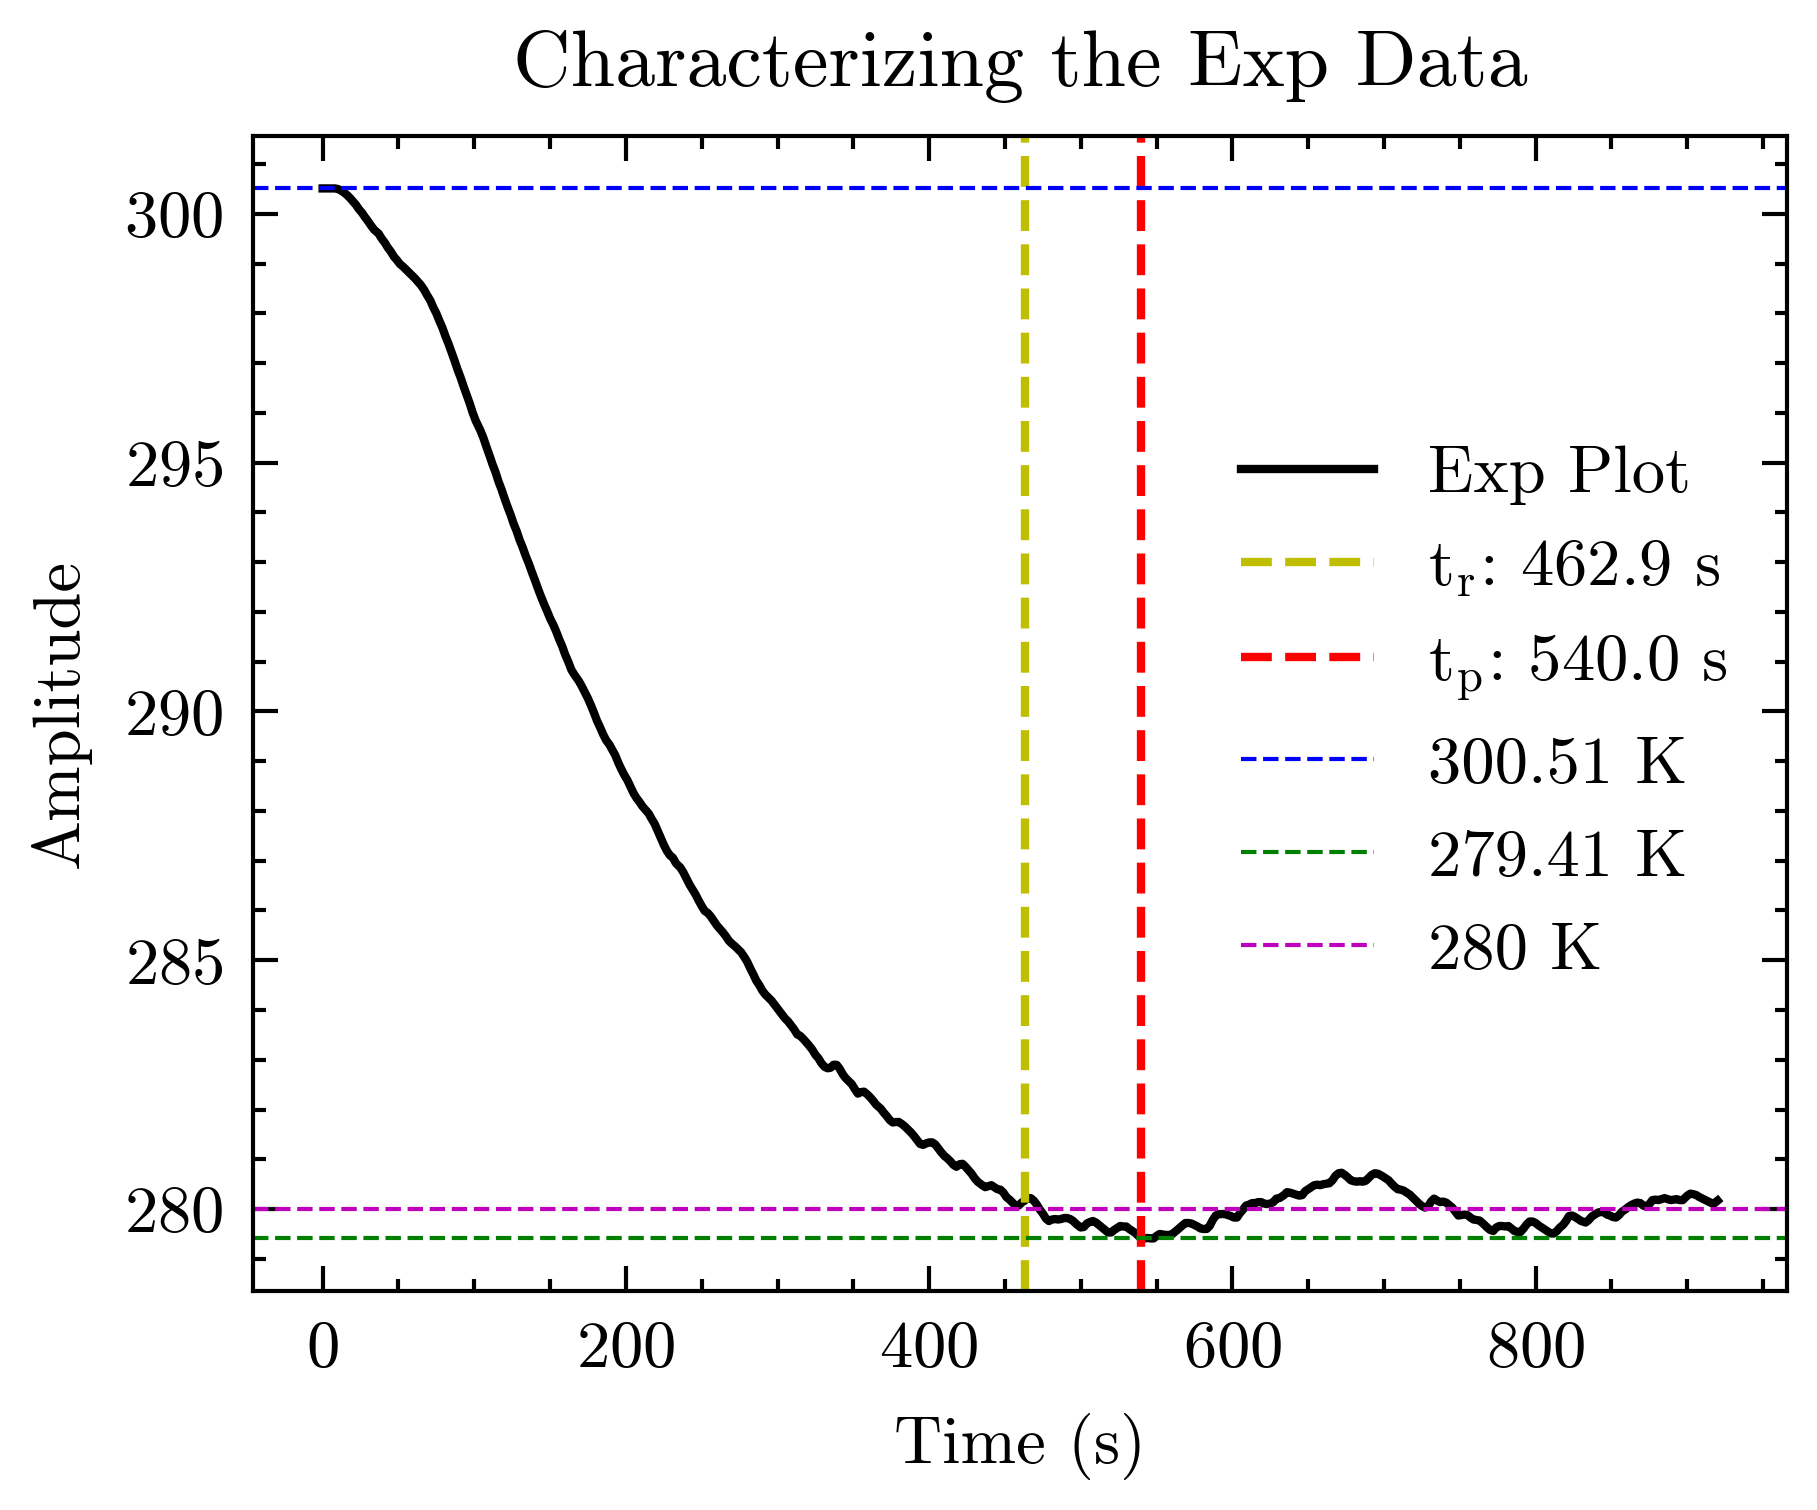

In [21]:
#plt.plot(t_model, tempcol, label = 'Model Plot')
plt.plot(elapsed_time_seconds, tempcol, color='k', label = 'Exp Plot')

index_peak_model = np.where(tempcol == T_peak)
peak_timeseries_model = (elapsed_time_seconds[index_peak])
#print(peak_timeseries_model)
plt.axvline(x = rise_time, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 1)} s')
plt.axvline(x = peak_time, color='r', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{peak_time} s')
#plt.axhline(y = 280, color='g', linestyle='--', label = '280 K')
plt.axhline(max(testcol), linestyle='dashed', color='b', linewidth = 0.5, label = f'{max(tempcol)} K')  # Adjusted dashed line
plt.axhline(min(testcol), linestyle='dashed', color='g', linewidth = 0.5, label = f'{min(tempcol)} K')  # Adjusted dashed line
plt.axhline(280, color='m', linewidth = 0.5, linestyle='--', label = '280 K')
plt.title('Characterizing the Exp Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")

#plt.savefig('log_3105_exp_character.pdf', dpi=300)
plt.show()

#### ARCHIVED CODE

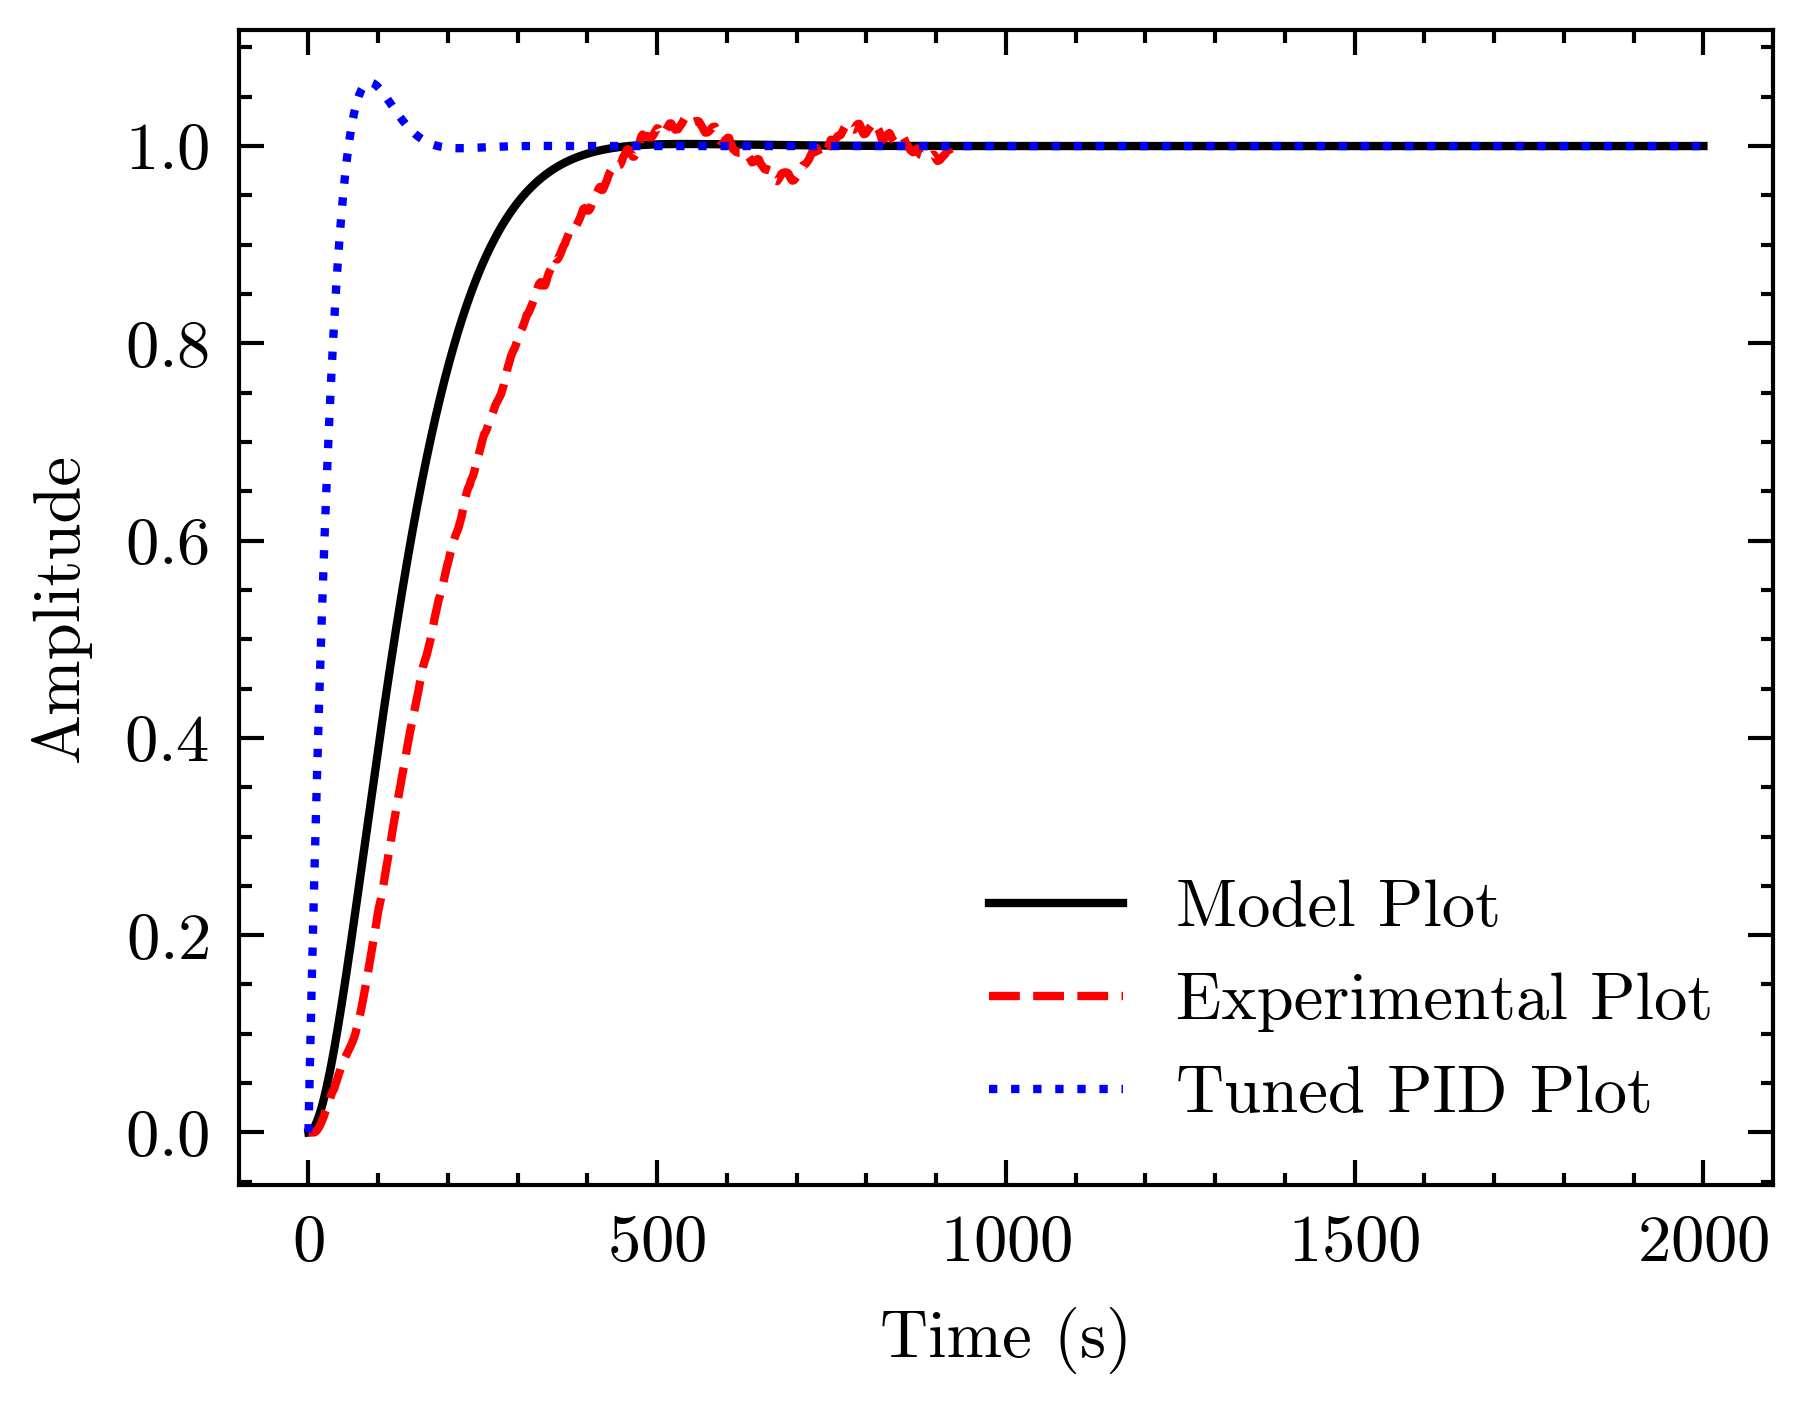

In [361]:

kp = 5
ki = 0.5
kd = 0.2

P = (w_n ** 2) / (((s ** 2) * kd + s * kp + ki) * (s + 2 * w_n * damp_f))

plt.figure()
t, y = ct.step_response(P)
# plt.plot(t, y)

kp = 5
ki = 0.5
kd = 0.2
C = ct.TransferFunction([kd, kp, ki], [1, 0])
T = ct.feedback(C * P, 1)

t_model = np.arange(0, 2000, 0.01)
t_model, y_model = ct.step_response(T, t_model)

plt.plot(t_model, y_model, label = 'Model Plot')
plt.plot(elapsed_time_seconds, tempcol_normalized, label = 'Experimental Plot')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")
# Find the index of the maximum value of y
# max_idx = np.argmax(y)
# max_x = t[max_idx]

# # Add vertical line at the highest point
#plt.axhline(y = 280, color='y', linestyle='--')

# Annotate the x value at the highest point
#plt.text(max_x, 1.2, f'x={max_x:.2f}', rotation=0, verticalalignment='bottom')
#plt.gca().invert_yaxis()

kp = 136.675
ki = 4.1025
kd = 1024.7449
C = ct.TransferFunction([kd, kp, ki], [1, 0])
T = ct.feedback(C * P, 1)

t_tuned = np.arange(0, 2000, 0.01)
t_tuned, y_tuned = ct.step_response(T, t_tuned)

plt.plot(t_tuned, y_tuned, label = 'Tuned PID Plot')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")

# Find the index of the maximum value of y
# max_idx = np.argmax(y)
# max_x = t[max_idx]

# # Add vertical line at the highest point
#plt.axhline(y = 1.002107142855882, color='y', linestyle='--')
#plt.axvline(x = 2.66, color='y', linestyle='--')

# Annotate the x value at the highest point
#plt.text(max_x, 1.2, f'x={max_x:.2f}', rotation=0, verticalalignment='bottom')
#plt.gca().invert_yaxis()

plt.savefig('log_3105_model_exp_tuned.pdf', dpi=300)
plt.show()

### CHARACTERIZING THE MODEL DATA

In [24]:
min(tempcol), min(y_model_unnorm)

(279.41, 279.95678250002584)

In [26]:
# Find peak temperature and peak time
T_peak_model = min(y_model_unnorm)
#print(max(y_model))
index_peak_model = np.where(y_model_unnorm == T_peak_model)[0][0]
peak_timeseries_model = (t_model[index_peak_model])

#print(peak_timeseries_model)
starttime_model = 0
peak_time_model = (peak_timeseries_model - starttime_model)

print("Peak temperature:", round(T_peak_model,3), "K")

# Find overshoot
set_t_model = 280
overshoot_model = ((T_peak_model - set_t_model)/set_t_model) 

# Print percentage overshoot
print("Percentage overshoot:", round((overshoot_model*100),2), "%")
damp_f_model = math.sqrt( 1 / ( 1 + ( (math.pi**2) / ((math.log(np.abs(overshoot_model)))**2) )))
w_n_model = math.pi / (peak_time_model * math.sqrt(1 - (damp_f_model ** 2)))

theta_model = (math.atan(math.sqrt((1-(damp_f_model**2))/damp_f_model)))
rise_time_model = (math.pi - theta_model)/(w_n_model * math.sqrt(1-(damp_f_model**2)))
print("Peak time:", round(peak_time_model,2), "s")
print("Rise time:", round(rise_time_model,2), "s")

print("Damping Factor:", round(damp_f_model,2))
print("Natural Frequency:", round(w_n_model,2), "rad/s")

Peak temperature: 279.957 K
Percentage overshoot: -0.02 %
Peak time: 540.0 s
Rise time: 482.54 s
Damping Factor: 0.94
Natural Frequency: 0.02 rad/s


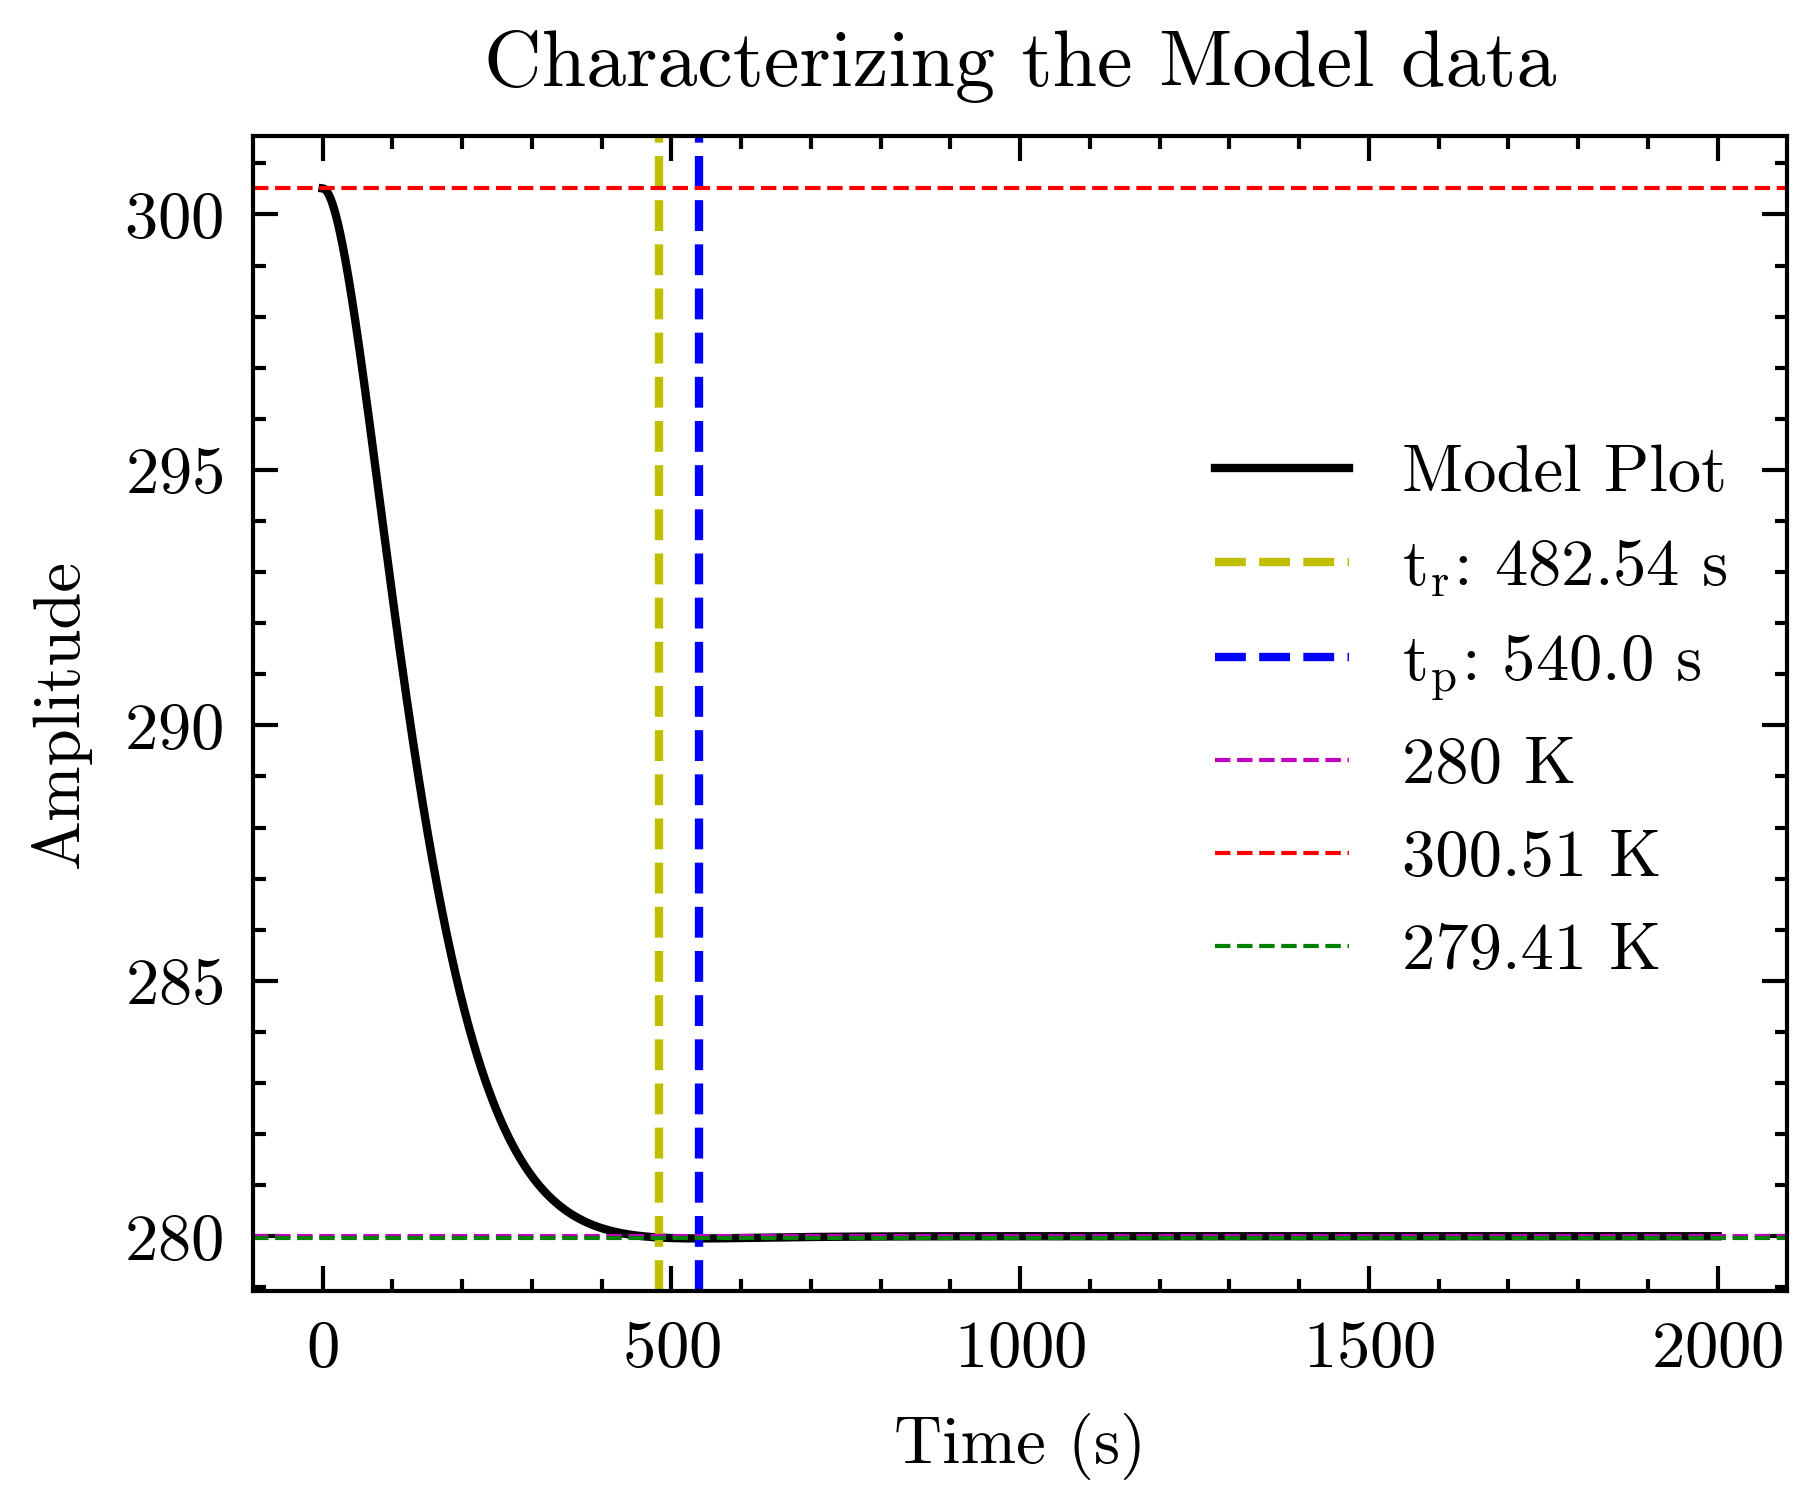

In [43]:
plt.plot(t_model, y_model_unnorm, color='k', label = 'Model Plot')
#plt.plot(elapsed_time_seconds, tempcol, color= 'r', label = 'Exp Plot')

index_peak_model = np.where(y_model == T_peak_model)
peak_timeseries_model = (t_model[index_peak_model])
#print(peak_timeseries_model)
plt.axvline(x = rise_time_model, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time_model, 2)} s')
plt.axvline(x = peak_time_model, color='b', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{peak_time_model} s')
plt.axhline(y = 280, color='m', linestyle='--', linewidth = 0.5, label = '280 K')
plt.axhline(max(y_model_unnorm), linestyle='dashed', color='r', linewidth = 0.5, label = f'{max(testcol)} K')  # Adjusted dashed line
plt.axhline(min(y_model_unnorm), linestyle='dashed', color='g', linewidth = 0.5, label = f'{min(testcol)} K')  # Adjusted dashed line
plt.title('Characterizing the Model data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

#plt.ylim(279.75, 280.25)
plt.legend(loc="best")

plt.savefig('log_3105_model_character.pdf', dpi=300)
plt.show()

### CHARACTERIZING THE TUNED DATA

In [41]:
# Find peak temperature and peak time
T_peak_tuned = min(y_tuned_unnorm)
#print(max(y_tuned))
index_peak_tuned = np.where(y_tuned_unnorm == T_peak_tuned)[0][0]
peak_timeseries_tuned = (t_model[index_peak_tuned])

#print(peak_timeseries_model)
starttime_tuned = 0
peak_time_tuned = (peak_timeseries_tuned - starttime_tuned)

print("Peak temperature:", round(T_peak_tuned,3), "K")

# Find overshoot
set_t_tuned = 280
overshoot_tuned = ((T_peak_tuned - set_t_tuned)/set_t_tuned) 

# Print percentage overshoot
print("Percentage overshoot:", round((overshoot_tuned*100),2), "%")
damp_f_tuned = math.sqrt( 1 / ( 1 + ( (math.pi**2) / ((math.log(np.abs(overshoot_tuned)))**2) )))
w_n_tuned = math.pi / (peak_time_tuned * math.sqrt(1 - (damp_f_tuned ** 2)))

theta_tuned = (math.atan(math.sqrt((1-(damp_f_tuned**2))/damp_f_tuned)))
rise_time_tuned = (math.pi - theta_tuned)/(w_n_tuned * math.sqrt(1-(damp_f_tuned**2)))
print("Peak time:", round(peak_time_tuned,2), "s")
print("Rise time:", round(rise_time_tuned,2), "s")

print("Damping Factor:", round(damp_f_tuned,2))
print("Natural Frequency:", round(w_n_tuned,2), "rad/s")

Peak temperature: 278.727 K
Percentage overshoot: -0.45 %
Peak time: 87.73 s
Rise time: 73.87 s
Damping Factor: 0.86
Natural Frequency: 0.07 rad/s


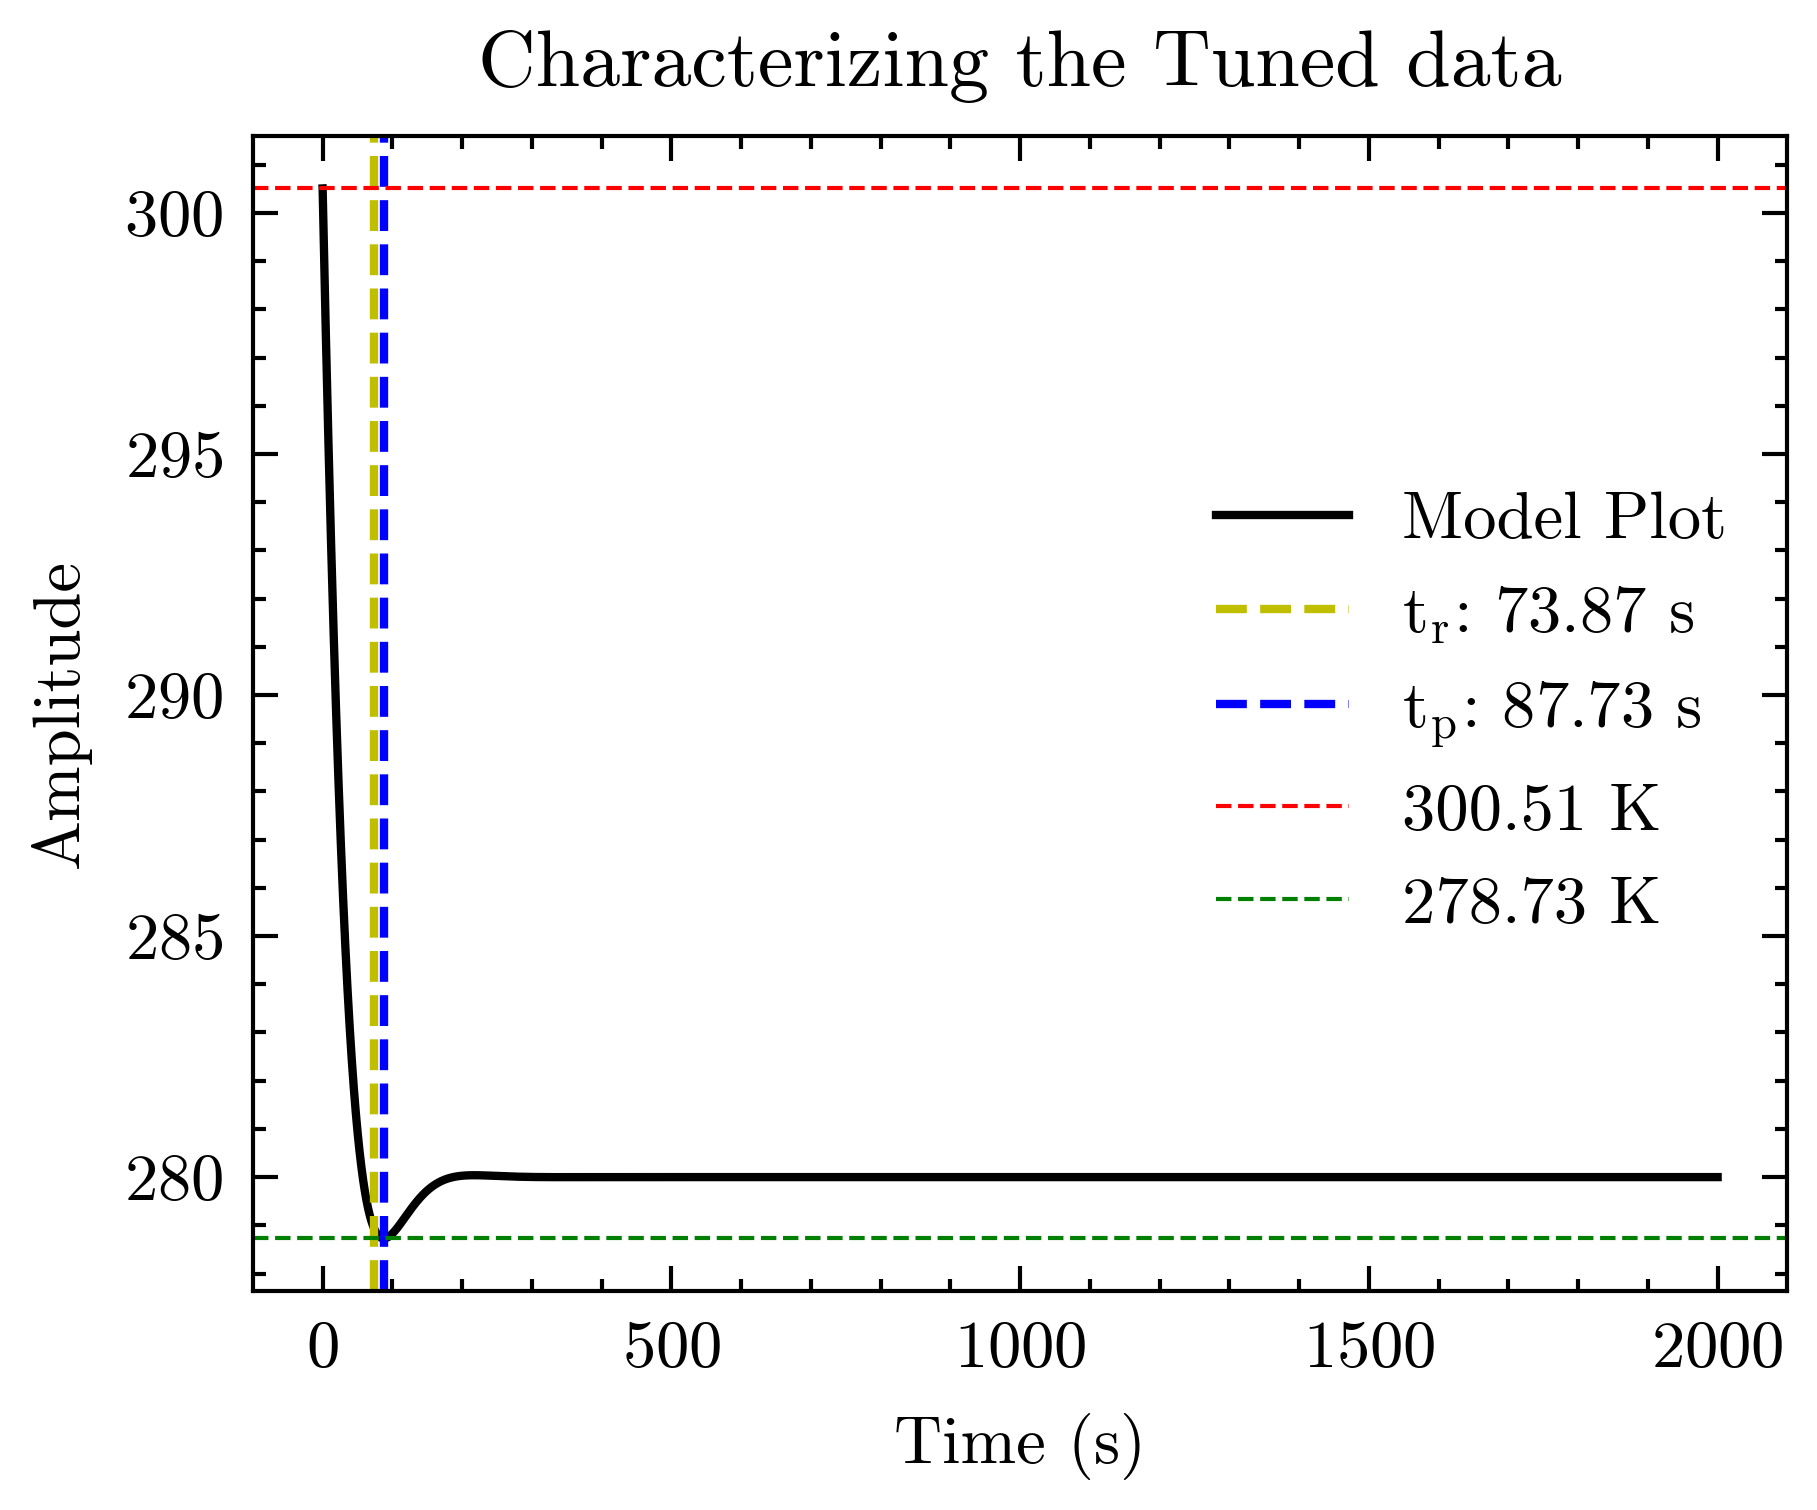

In [42]:
plt.plot(t_tuned, y_tuned_unnorm, color='k', label = 'Model Plot')
#plt.plot(elapsed_time_seconds, tempcol, color= 'r', label = 'Exp Plot')

#print(peak_timeseries_model)
plt.axvline(x = rise_time_tuned, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time_tuned, 2)} s')
plt.axvline(x = peak_timeseries_tuned, color='b', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{round(peak_timeseries_tuned, 2)} s')
#plt.axhline(y = 280, color='g', linestyle='--', label = '280 K')
plt.axhline(max(y_tuned_unnorm), linestyle='dashed', color='r', linewidth = 0.5, label = f'{max(y_tuned_unnorm)} K')  # Adjusted dashed line
plt.axhline(min(y_tuned_unnorm), linestyle='dashed', color='g', linewidth = 0.5, label = f'{round(min(y_tuned_unnorm),2)} K')  # Adjusted dashed line
plt.title('Characterizing the Tuned data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc="best")

#plt.savefig('log_3105_tuned_character.pdf', dpi=300)
plt.show()

array([[list([<matplotlib.lines.Line2D object at 0x0000014CBBD0AF90>]),
        list([<matplotlib.lines.Line2D object at 0x0000014CC2A93D90>]),
        list([<matplotlib.lines.Line2D object at 0x0000014CC2A1C290>, <matplotlib.lines.Line2D object at 0x0000014CC2A1C610>, <matplotlib.lines.Line2D object at 0x0000014CC2A1E610>, <matplotlib.lines.Line2D object at 0x0000014CC2A1D190>])]],
      dtype=object)

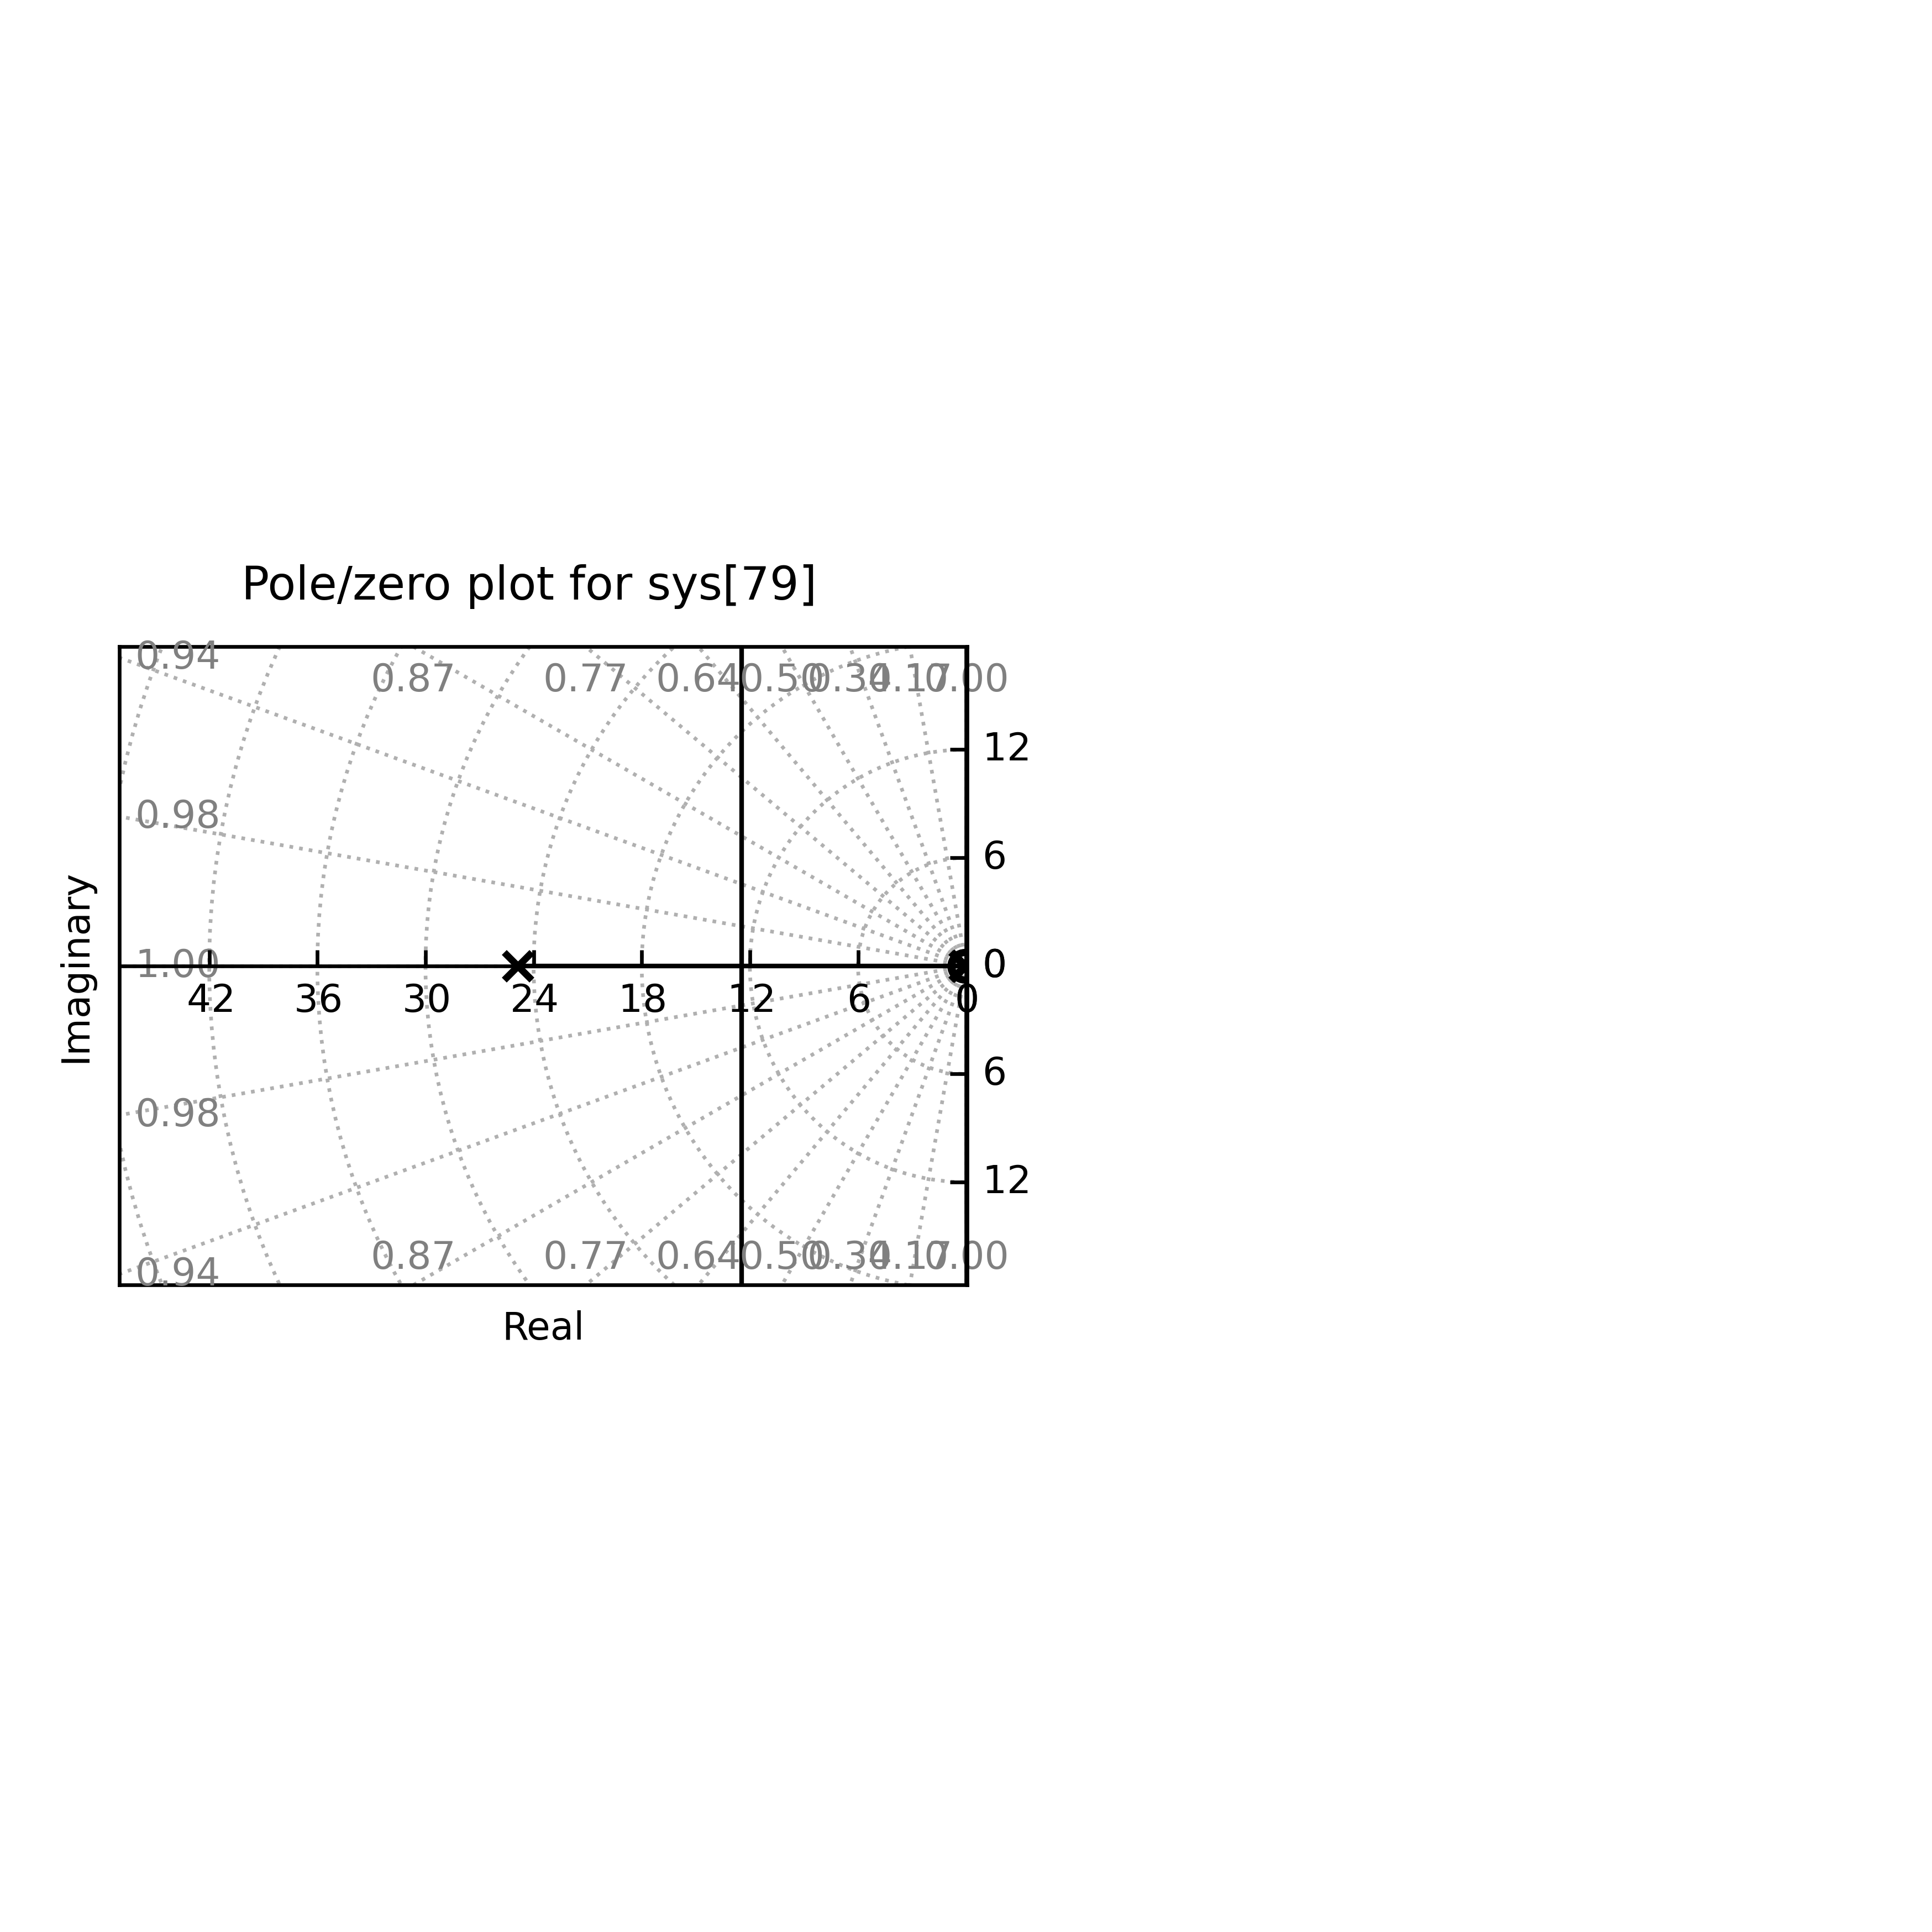

In [45]:
ct.root_locus_map(T).plot()

In [47]:
# Function to format poles and zeros
def format_complex_array(arr):
    formatted = []
    for num in arr:
        # If the imaginary part is very close to zero, just print the real part
        if np.isclose(num.imag, 0):
            formatted.append(f"{num.real:.6f}")
        else:
            formatted.append(f"{num.real:.6f} + {num.imag:.6f}j")
    return formatted

# Format poles and zeros
poles = ct.poles(T)
zeros = ct.zeros(T)
formatted_poles = format_complex_array(poles)
formatted_zeros = format_complex_array(zeros)
s
print("Poles:", formatted_poles)
print("Zeros:", formatted_zeros)

Poles: ['-24.865804', '-0.103220', '-0.026900 + 0.024242j', '-0.026900 + -0.024242j']
Zeros: ['-0.091640', '-0.043687']
